In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [2]:


import numpy as np

# build the data matrix
data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)
data_linear_model.mean()["speed*sin(alpha)"]

-0.002709709612566326

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

# create the model
linear_model = make_pipeline(StandardScaler(), RidgeCV())

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_linear_model["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [73.23006461 72.1311734  72.89061823 71.2370263 ]
 mean +/- std: 72.372 +/- 0.767 Watts


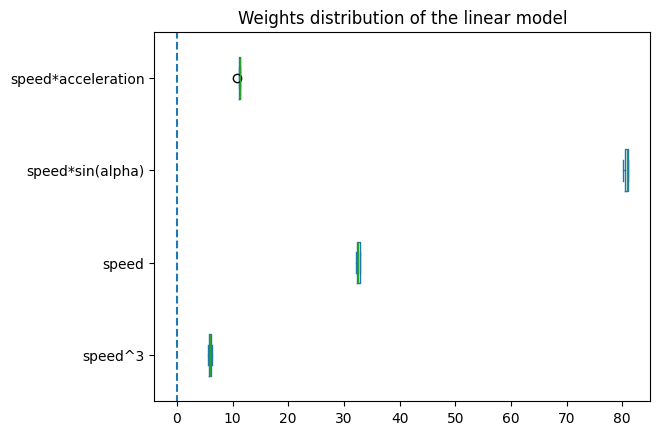

In [4]:
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_results_linear_model["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42
)

cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True, n_jobs=2)

errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [44.39516221 44.13036203 43.75817    43.06094014]
 mean +/- std: 43.836 +/- 0.502 Watts


In [6]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:	 73.015 +/- 5.779 Watts
Histogram GBDT - MAE on train sets:	 40.131 +/- 1.295 Watts
Histogram GBDT - MAE on test sets:	 49.204 +/- 2.694 Watts


In [7]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

In [8]:
len(groups)

38254

In [9]:
cv_results_linear_model2 = cross_validate(
    linear_model, data_train, target_train, groups=groups[train_indices], cv=cv,
    scoring="r2", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt2 = cross_validate(
    hgbdt, data_train, target_train, groups=groups[train_indices], cv=cv,
    scoring="r2", return_estimator=True,
    return_train_score=True, n_jobs=2)

In [10]:
cv_results_linear_model2

{'fit_time': array([0.01500511, 0.01500511, 0.01151085]),
 'score_time': array([0.00199962, 0.00199962, 0.00199962]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])],
 'test_score': array([ 0.40232436, -0.68951739,  0.19863028]),
 'train_score': array([0.38603605, 0.42458925, 0.40910268])}

In [11]:
cv_results_hgbdt2

{'fit_time': array([0.49572778, 0.35218835, 0.50786281]),
 'score_time': array([0.03899813, 0.02899885, 0.03150845]),
 'estimator': [HistGradientBoostingRegressor(early_stopping=True, max_iter=1000,
                                random_state=42),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000,
                                random_state=42),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000,
                                random_state=42)],
 'test_score': array([0.57154133, 0.5661696 , 0.38563932]),
 'train_score': array([0.75179498, 0.74312502, 0.73373829])}

In [12]:
import seaborn as sns

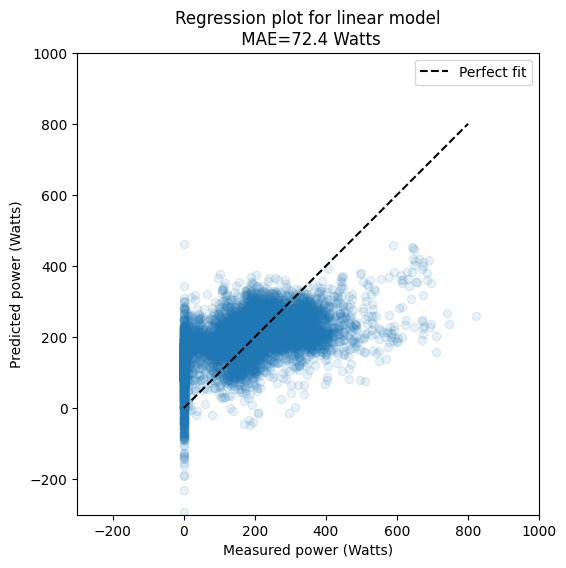

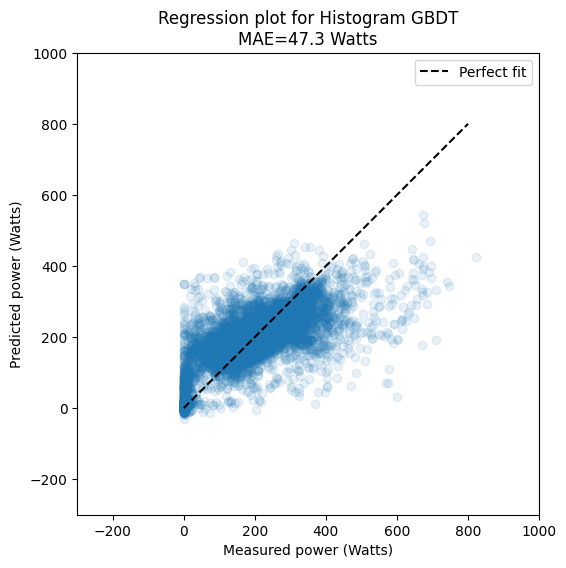

In [13]:
from sklearn.metrics import mean_absolute_error

# fit models and collect predictions
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)
# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

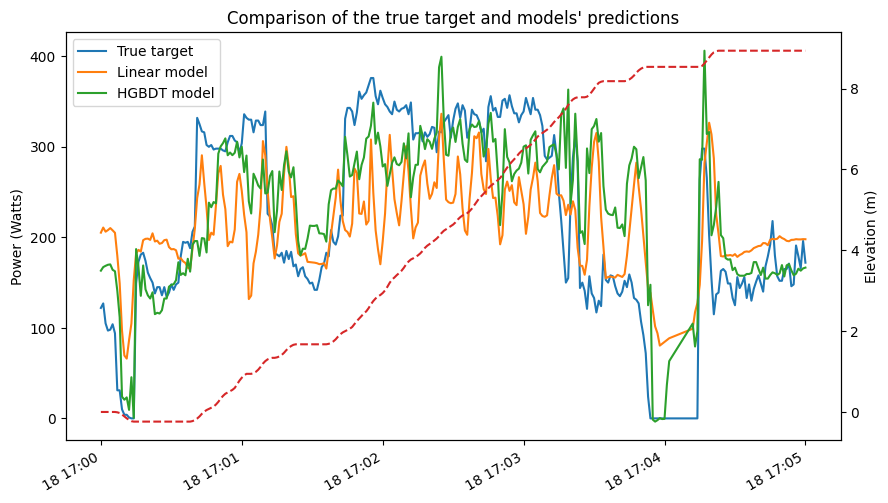

In [14]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")